In [1]:
!pip install psaw
import pandas as pd
import re
import matplotlib.pyplot as plt
from psaw import PushshiftAPI
import datetime as dt
import datetime
from datetime import date
import seaborn
seaborn.set()
import warnings
warnings.filterwarnings("ignore")

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


# Uncomment if using Google Colab with Google drive

In [2]:
## Uncomment it if you are using Google Collab
# import os
# from google.colab import drive
# drive.mount('/content/drive/')
# %cd /content/drive/MyDrive/cmpt353-group-project/

#  Importing files

In [3]:
# importing ticker symbols
tickers = pd.read_csv('./data/Processed_data/stock_ticker.csv')

# read the files.
reddit_posts = pd.read_csv('./data/Raw_data/reddit_wsb.csv')
reddit_comments1 = pd.read_csv('./data/Raw_data/comments_2020-11-1_2020-11-30_new.csv')
reddit_comments2 = pd.read_csv('./data/Raw_data/comments_2020-12-1_2020-12-31_new.csv')
reddit_comments3 = pd.read_csv('./data/Raw_data/comments_2021-1-1_2021-11-29_new.csv')


# Extracting Reddit posts (Navjot & Jyotiraditya) 

Using CSV files (Navjot)

In [4]:
#drop the rows with no data
reddit_posts = reddit_posts.drop(['score', 'id', 'url', 'comms_num', 'created'], axis=1)
reddit_comments1 = reddit_comments1.dropna()
reddit_comments2 = reddit_comments2.dropna()
reddit_comments3 = reddit_comments3.dropna()

# reference from https://stackoverflow.com/questions/60738190/regular-expression-to-find-a-series-of-uppercase-words-in-a-string

#finding tickers in the text
pattern = r'\b([A-Z]+(?:\'+[A-Z]+)*\b)'
def contains_uppercase(title):
    list_uppercase = re.findall(pattern, title)
    return list_uppercase

total_list = [reddit_posts['title'], reddit_posts['body'], reddit_comments1['Body'], reddit_comments2['Body'], reddit_comments3['Body']]
total_list = pd.concat(total_list)
total_list = total_list.dropna()
total_list = pd.DataFrame(total_list, columns=['text'])
list_words = total_list['text'].apply(contains_uppercase)
total_list['uppercase'] = list_words
total_list = total_list[total_list['uppercase'].apply(len) > 0]
list_words = list_words[list_words.apply(len) > 0]

list_combined = []
for i in list_words:
  list_combined.extend(i)

#extracted which ticker has the most count
list_combined.sort()
df_combined = pd.DataFrame(list_combined, columns = ['Ticker'])
df_combined['count'] = 1
df_combined['contains'] = df_combined['Ticker'].isin(tickers['Symbol'])
df_combined = df_combined[df_combined['contains'] != False]
#reference from https://datascienceparichay.com/article/pandas-groupby-count-of-rows-in-each-group/
df_combined = df_combined.groupby('Ticker').count()
df_combined = df_combined.drop(['contains'], axis = 1)
df_combined = df_combined.reset_index(drop=False)

#filtering the obvious words which could cause noise
df_combined = df_combined.sort_values(by=['count'], ascending=False)

df_combined = df_combined.reset_index(drop=True)
df_combined_10 = df_combined.head(10)





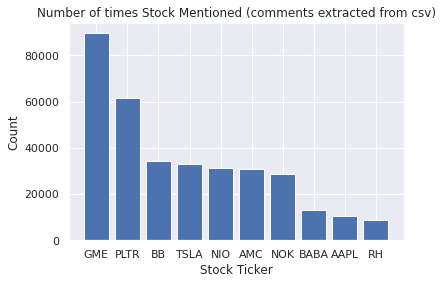

In [5]:
# Plotting histogram for words and their count
plt.bar(df_combined_10['Ticker'],df_combined_10['count'])
plt.xlabel('Stock Ticker')
plt.ylabel('Count')
plt.title('Number of times Stock Mentioned (comments extracted from csv)')
plt.savefig('./data/Plots/Num_times_stock_mentioned_from_csv.png')
plt.show()


Using API (Jyotiraditya)

In [6]:
# using API to extract the reddit posts from most famous stock market Subreddits
api = PushshiftAPI()
start_epoch = int(dt.datetime(2021, 8, 1).timestamp())
end = int(dt.datetime(2021,8,12).timestamp())

# Wallstreetbets
result = list(api.search_submissions(after=start_epoch, before = end,
                           subreddit='wallstreetbets',
                           filter=['title'], limit=1000))
#Stocks
result_stocks=list(api.search_submissions(after=start_epoch, before = end,
                           subreddit='stocks',
                           filter=['title'], limit=1000))
#Robinhood
result_robin=list(api.search_submissions(after=start_epoch, before = end,
                           subreddit='robinhood',
                           filter=['title'], limit=1000))

#Dogecoin
result_doge=list(api.search_submissions(after=start_epoch, before = end,
                           subreddit='dogecoin',
                           filter=['title'], limit=1000))

# fitering stock tickers from subreddit comments
ticker = []
pattern = r'\b([A-Z]+(?:\'+[A-Z]+)*\b)'
for r in result:
  split = r.title.split()
  ticker.append(list(filter(lambda word: re.findall(pattern, word),split)))
for r in result_stocks:
  split = r.title.split()
  ticker.append(list(filter(lambda word: re.findall(pattern, word), split)))
for r in result_robin:
 split = r.title.split()
 ticker.append(list(filter(lambda word: re.findall(pattern, word), split)))
for r in result_doge:
 split = r.title.split()
 ticker.append(list(filter(lambda word: re.findall(pattern, word), split)))

# combining stock_tickers
list_combined = []
for i in ticker:
  list_combined.extend(i)

# print(list_combined)
df_combined = pd.DataFrame(list_combined, columns = ['Ticker'])
df_combined['count'] = 1
df_combined['Ticker'] = df_combined['Ticker'].str.upper()
df_combined['contains'] = df_combined['Ticker'].isin(tickers['Symbol'])
df_combined = df_combined[df_combined['contains'] != False]
# #reference from https://datascienceparichay.com/article/pandas-groupby-count-of-rows-in-each-group/
df_combined = df_combined.groupby('Ticker').count()
df_combined = df_combined.drop(['contains'], axis = 1)
# df_combined = df_combined.reset_index(drop=False)

df_combined=df_combined.sort_values('count', ascending = False)

df_combined['Ticker'] = df_combined.index

#filtering the obvious words which could cause noise

df_combined = df_combined.reset_index(drop=True)
df_combined_10 = df_combined.head(10)

df_combined_10.to_csv('./data/Processed_data/df_combined_10.csv')
df_combined.to_csv('./data/Processed_data/df_combined.csv')

df_combined_10

,count,Ticker
0,49,AMC
1,15,GME
2,15,HOOD
3,12,ON
4,10,RH
5,9,CLOV
6,9,MRNA
7,8,MVST
8,8,GE
9,7,AMD


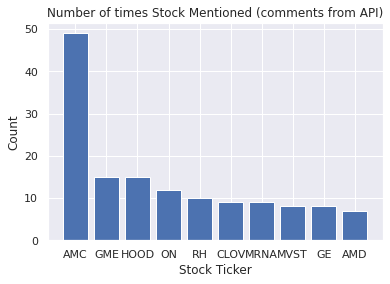

In [7]:

# Plotting histogram for words and their count
plt.bar(df_combined_10['Ticker'],df_combined_10['count'])
plt.xlabel('Stock Ticker')
plt.ylabel('Count')
plt.title('Number of times Stock Mentioned (comments from API)')
plt.savefig('./data/Plots/Num_times_stock_mentioned_from_API_comments.png')
plt.show()
